# Group 1 - Predicting Airbnb Prices in Europe

Based on features like *room_type*, *location*, and *ratings*, can we predict Airbnb prices across major European cities?

## Dataset Description

***Kaggle Link:*** https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities/data?select=london_weekdays.csv

- ***weekend:***  1 if its a weekend and 0 if it is not

- ***host_is_superhost:***  if a host is a superhost, they meet these requirements (source: https://www.airbnb.com/help/article/829) :

    - Hosted at least 10 reservations, or 3 reservations that total at least 100 nights
    - Maintained a 90% or higher response rate
    - Maintained a less than 1% cancellation rate, with exceptions for cancellations due to Major Disruptive Events or other valid reasons
    - Maintained a 4.8 or higher overall rating (A review counts towards Superhost status when either both the guest and the host have submitted a review, or the 14-day window for reviews is over, whichever comes first.)

- ***bedrooms:***  in the case that bedrooms = 0, it might be because the listing is for a studio

- ***multiple_room:***  1 if listing is for multiple rooms, 0 otherwise.

- ***spare_room:***  if a listing is NOT for multiple rooms and is NOT for business purpose, then the listing is only for one room

- ***business_purpose:***  1 if it is for business purpose (full time income generating) or not (personal use, for example renting out a spare room for a few weeks). For this classification, we assume that business listings typically feature more rooms than the threshold for multiple rooms column. This is because we noticed that there are listings that are NOT multiple rooms and NOT for business purpose.

- ***price:*** we took the natural log of the price because we noticed that the price is very skewed.

In [60]:
# Data Preprocessing
import pandas as pd
import numpy as np
import zipfile
import os

# Exploratory Data Analysis
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Principal Component Analysis
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import decomposition

import warnings
warnings.filterwarnings("ignore")

## Data Preprocessing

Let's preprocess the datasets in *Airbnb_data.zip* to understand the features and how to proceed with Exploratory Data Analysis (EDA).

In [61]:
# # Load Dataset - COLAB
# from google.colab import files
# uploaded = files.upload()
# !unzip Airbnb_data.zip

# datasets = {}
# for _, _, filenames in os.walk("Airbnb_data"):
#   for file_name in filenames:
#     name = file_name.split(".")[0]
#     datasets[name] = pd.read_csv("Airbnb_data/" + file_name)
# datasets

In [62]:
# Load Dataset - VSCode
path = "Airbnb_data.zip"
folder = "Airbnb_data"

# extract zipfile
with zipfile.ZipFile(path, "r") as zip_ref:
    zip_ref.extractall(folder)

# list extracted files
files = os.listdir(folder)
print(f"Extracted Files: {files}\n")

# load csv files
datasets = {}

for file in files:
    if file.endswith(".csv"):
        print(f"Loading file: {file}")
        path = os.path.join(folder, file)
        df = pd.read_csv(path)
        datasets[file.rsplit(".", 1)[0]] = df # remove ".csv"

Extracted Files: ['amsterdam_weekdays.csv', 'barcelona_weekends.csv', 'Airbnb_data', 'rome_weekdays.csv', 'berlin_weekdays.csv', 'budapest_weekdays.csv', 'vienna_weekdays.csv', 'london_weekdays.csv', 'lisbon_weekends.csv', 'athens_weekends.csv', 'paris_weekends.csv', 'barcelona_weekdays.csv', '__MACOSX', 'berlin_weekends.csv', 'rome_weekends.csv', 'amsterdam_weekends.csv', 'athens_weekdays.csv', 'paris_weekdays.csv', 'vienna_weekends.csv', 'budapest_weekends.csv', 'lisbon_weekdays.csv', 'london_weekends.csv']

Loading file: amsterdam_weekdays.csv
Loading file: barcelona_weekends.csv
Loading file: rome_weekdays.csv
Loading file: berlin_weekdays.csv
Loading file: budapest_weekdays.csv
Loading file: vienna_weekdays.csv
Loading file: london_weekdays.csv
Loading file: lisbon_weekends.csv
Loading file: athens_weekends.csv
Loading file: paris_weekends.csv
Loading file: barcelona_weekdays.csv
Loading file: berlin_weekends.csv
Loading file: rome_weekends.csv
Loading file: amsterdam_weekends.csv

Now that we've loaded the airbnb datasets, we can continue with data preprocessing to prepare it for EDA.

### i) Add "City" & "Weekend" Columns

In [63]:
# Add "city" & "weekend" Columns
for name, dataset in datasets.items():
    city, weekend = name.split("_")
    dataset["city"] = city
    dataset["weekend"] = weekend == "weekends"
    dataset["weekend"] = dataset["weekend"].astype(int)

### ii) Combine Datasets

In [64]:
# Combine Datasets
df = pd.concat([datasets[file_name] for file_name in datasets])
df.head()

,Unnamed: 0,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,weekend
0,0,194.033698,Private room,False,True,2.0,False,1,0,10.0,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,amsterdam,0
1,1,344.245776,Private room,False,True,4.0,False,0,0,8.0,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,amsterdam,0
2,2,264.101422,Private room,False,True,2.0,False,0,1,9.0,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,amsterdam,0
3,3,433.529398,Private room,False,True,4.0,False,0,1,9.0,...,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,amsterdam,0
4,4,485.552926,Private room,False,True,2.0,True,0,0,10.0,...,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,amsterdam,0


***Observation:*** Based on the concatenated airbnb dataset, we see that the *unnamed* column is simply the index from the original dataset. We don't need this anymore...

### iii) Clean Data

First, let's standardize the column names for better readability and consistency.

In [65]:
# Standardize Column Names
name = {'realSum' :'price',
        'biz': 'business_purpose',
        'multi' : 'multiple_rooms',
        'dist' : 'dist_city_center',
        'metro_dist' : 'dist_metro_station',
        'lng' : 'longitude',
        'lat':'latitude'
        }

df = df.rename(columns = name)
df.head()

,Unnamed: 0,price,room_type,room_shared,room_private,person_capacity,host_is_superhost,multiple_rooms,business_purpose,cleanliness_rating,...,dist_city_center,dist_metro_station,attr_index,attr_index_norm,rest_index,rest_index_norm,longitude,latitude,city,weekend
0,0,194.033698,Private room,False,True,2.0,False,1,0,10.0,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,amsterdam,0
1,1,344.245776,Private room,False,True,4.0,False,0,0,8.0,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,amsterdam,0
2,2,264.101422,Private room,False,True,2.0,False,0,1,9.0,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,amsterdam,0
3,3,433.529398,Private room,False,True,4.0,False,0,1,9.0,...,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,amsterdam,0
4,4,485.552926,Private room,False,True,2.0,True,0,0,10.0,...,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,amsterdam,0


***Observation:*** The *Unnamed* column is redundant and unecessary as it's the same as the original dataset's indices.

So let's drop *Unnamed* from the dataset.

In [66]:
# Drop "Unnamed" Column
df = df.drop(columns =['Unnamed: 0'])
df.head()

,price,room_type,room_shared,room_private,person_capacity,host_is_superhost,multiple_rooms,business_purpose,cleanliness_rating,guest_satisfaction_overall,...,dist_city_center,dist_metro_station,attr_index,attr_index_norm,rest_index,rest_index_norm,longitude,latitude,city,weekend
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,amsterdam,0
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,amsterdam,0
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,amsterdam,0
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,...,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,amsterdam,0
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,...,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,amsterdam,0


Now let's look at the descriptive statistics of our new dataset. This will give us insight into skewness and outliers in the dataset that we will need to handle.

In [67]:
# Descriptive Statistics
df.describe()

,price,person_capacity,multiple_rooms,business_purpose,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist_city_center,dist_metro_station,attr_index,attr_index_norm,rest_index,rest_index_norm,longitude,latitude,weekend
count,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.00000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000
mean,279.879591,3.161661,0.291353,0.350204,9.390624,92.628232,1.15876,3.191285,0.681540,294.204105,13.423792,626.856696,22.786177,7.426068,45.671128,0.506837
std,327.948386,1.298545,0.454390,0.477038,0.954868,8.945531,0.62741,2.393803,0.858023,224.754123,9.807985,497.920226,17.804096,9.799725,5.249263,0.499958
min,34.779339,2.000000,0.000000,0.000000,2.000000,20.000000,0.00000,0.015045,0.002301,15.152201,0.926301,19.576924,0.592757,-9.226340,37.953000,0.000000
25%,148.752174,2.000000,0.000000,0.000000,9.000000,90.000000,1.00000,1.453142,0.248480,136.797385,6.380926,250.854114,8.751480,-0.072500,41.399510,0.000000
50%,211.343089,3.000000,0.000000,0.000000,10.000000,95.000000,1.00000,2.613538,0.413269,234.331748,11.468305,522.052783,17.542238,4.873000,47.506690,1.000000
75%,319.694287,4.000000,1.000000,1.000000,10.000000,99.000000,1.00000,4.263077,0.737840,385.756381,17.415082,832.628988,32.964603,13.518825,51.471885,1.000000
max,18545.450285,6.000000,1.000000,1.000000,10.000000,100.000000,10.00000,25.284557,14.273577,4513.563486,100.000000,6696.156772,100.000000,23.786020,52.641410,1.000000


***Observation:*** Based on the descriptive statistics, *price* is heavily skewed.

Let's use log to transform the *price* column so it's standardized.

In [68]:
# Standardize "price" Column
df["price"] = np.log(df['price'])
df.describe()

,price,person_capacity,multiple_rooms,business_purpose,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist_city_center,dist_metro_station,attr_index,attr_index_norm,rest_index,rest_index_norm,longitude,latitude,weekend
count,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.00000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000
mean,5.419519,3.161661,0.291353,0.350204,9.390624,92.628232,1.15876,3.191285,0.681540,294.204105,13.423792,626.856696,22.786177,7.426068,45.671128,0.506837
std,0.596600,1.298545,0.454390,0.477038,0.954868,8.945531,0.62741,2.393803,0.858023,224.754123,9.807985,497.920226,17.804096,9.799725,5.249263,0.499958
min,3.549024,2.000000,0.000000,0.000000,2.000000,20.000000,0.00000,0.015045,0.002301,15.152201,0.926301,19.576924,0.592757,-9.226340,37.953000,0.000000
25%,5.002282,2.000000,0.000000,0.000000,9.000000,90.000000,1.00000,1.453142,0.248480,136.797385,6.380926,250.854114,8.751480,-0.072500,41.399510,0.000000
50%,5.353483,3.000000,0.000000,0.000000,10.000000,95.000000,1.00000,2.613538,0.413269,234.331748,11.468305,522.052783,17.542238,4.873000,47.506690,1.000000
75%,5.767365,4.000000,1.000000,1.000000,10.000000,99.000000,1.00000,4.263077,0.737840,385.756381,17.415082,832.628988,32.964603,13.518825,51.471885,1.000000
max,9.827980,6.000000,1.000000,1.000000,10.000000,100.000000,10.00000,25.284557,14.273577,4513.563486,100.000000,6696.156772,100.000000,23.786020,52.641410,1.000000


Let's add a *spare_room* column to the dataset based on the *multiple_rooms* and *business_purpose* columns.

This will add more insight into the types of listings users are booking.

In [69]:
# Add "spare_room" Column
df['spare_room'] = ((df['multiple_rooms'] == 0) & (df['business_purpose'] == 0))
df.head()

,price,room_type,room_shared,room_private,person_capacity,host_is_superhost,multiple_rooms,business_purpose,cleanliness_rating,guest_satisfaction_overall,...,dist_metro_station,attr_index,attr_index_norm,rest_index,rest_index_norm,longitude,latitude,city,weekend,spare_room
0,5.268032,Private room,False,True,2.0,False,1,0,10.0,93.0,...,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,amsterdam,0,False
1,5.841356,Private room,False,True,4.0,False,0,0,8.0,85.0,...,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,amsterdam,0,True
2,5.576333,Private room,False,True,2.0,False,0,1,9.0,87.0,...,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,amsterdam,0,False
3,6.071960,Private room,False,True,4.0,False,0,1,9.0,90.0,...,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,amsterdam,0,False
4,6.185288,Private room,False,True,2.0,True,0,0,10.0,98.0,...,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,amsterdam,0,True


Now that we handled inconsistent data, we can handle missing data.

Let's see if and where our dataset has missing values so we can determine whether to drop or imputate it.

In [70]:
# Check Missing Data
np.sum(df.isnull(), axis = 0)

price                         0
room_type                     0
room_shared                   0
room_private                  0
person_capacity               0
host_is_superhost             0
multiple_rooms                0
business_purpose              0
cleanliness_rating            0
guest_satisfaction_overall    0
bedrooms                      0
dist_city_center              0
dist_metro_station            0
attr_index                    0
attr_index_norm               0
rest_index                    0
rest_index_norm               0
longitude                     0
latitude                      0
city                          0
weekend                       0
spare_room                    0
dtype: int64

***Observation:*** Our dataset has no null values! So there's no need to handle missing data and we can continue with our EDA.

## Exploratory Data Analysis (EDA)

Next, let's take an initial look at the features in our dataset, so we can gain more insight about their roles and characteristics.

### i) Feature Distributions

In [71]:
# Graph Functions
def init_subplots(rows, cols, figsize, df):
    fig, axes = plt.subplots(rows, cols, figsize=figsize) # init grid side
    axes = axes.flatten()
    cmap = cm.get_cmap('inferno', len(df.columns)) # inferno colors
    return fig, axes, cmap

def separate_features(df):
    numerical_cols = [col for col in df.columns if df[col].dtype == "float64"]
    categorical_cols = [col for col in df.columns if df[col].dtype != "float64"]
    all_columns = numerical_cols + categorical_cols
    return numerical_cols, categorical_cols, all_columns

def color_palette(cmap, idx, df, col):
    color = cmap(idx / len(df.columns))                 # create colormap
    unique_vals = df[col].nunique()                     # get unique vals
    palette = sns.color_palette("inferno", unique_vals) # map palette to unique vals
    return color, palette

def show_plots(df, fig, axes, layout):
    for i in range(len(df.columns) - 1, len(axes)): # hide unused subplots
        fig.delaxes(axes[i])

    if layout != None: fig.tight_layout(rect=layout) # setup layout
    else: fig.tight_layout()
    fig.show()
    return

In [72]:
# Initialize Plots
numerical_cols, categorical_cols, all_columns = separate_features(df) # separate types
num_numerical = len(numerical_cols)
num_categorical = len(categorical_cols)

Let's plot the distributions for *numerical features* in the dataset using *histograms*.

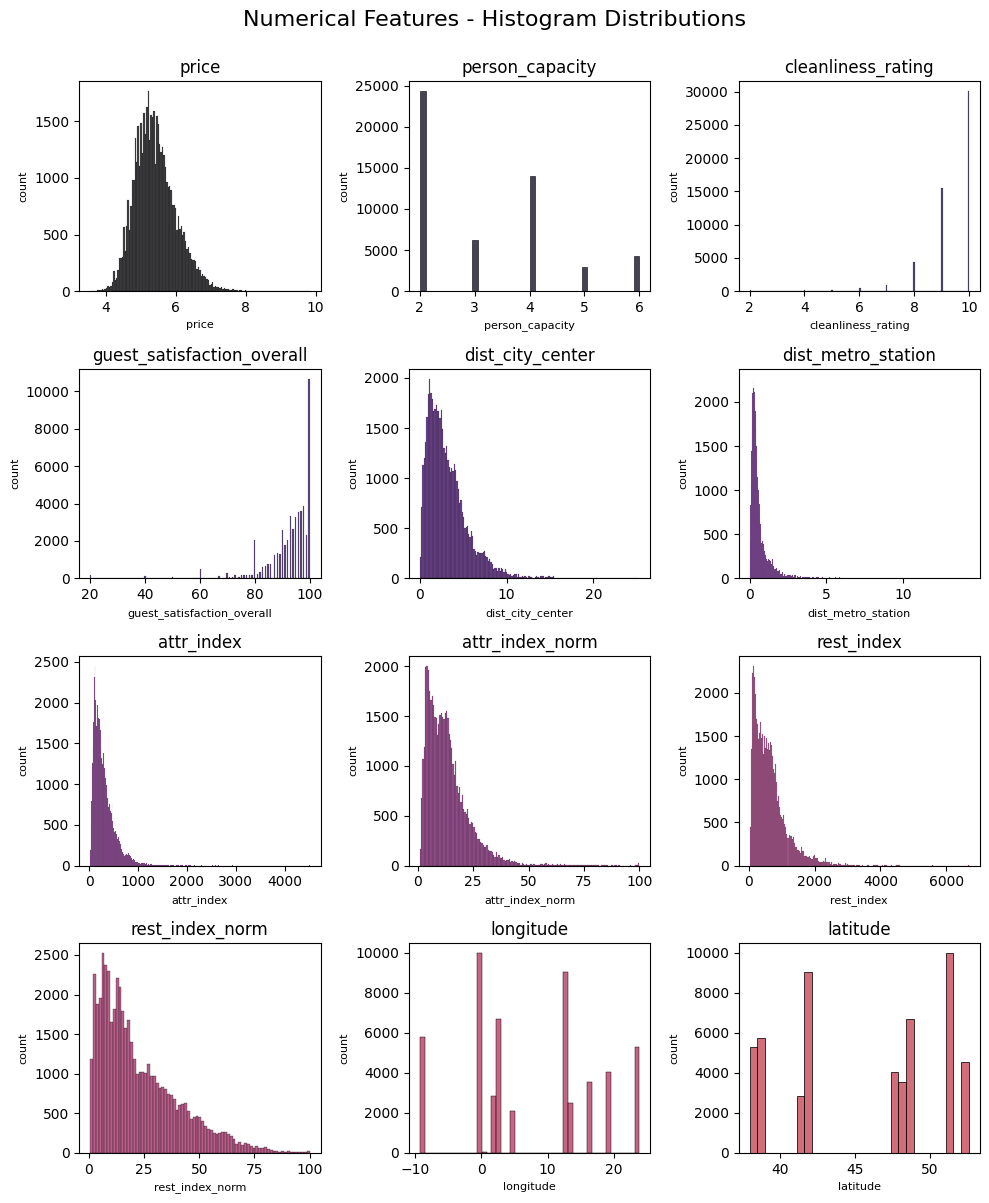

In [73]:
# Histogram Distributions - Numerical Features
fig, axes, cmap = init_subplots(4, 3, (10,12), df) # init subplot

for idx, col in enumerate(numerical_cols):
    ax = axes[idx]                               # get subplot idx
    color, _ = color_palette(cmap, idx, df, col) # init color
    sns.histplot(df, x=col, ax=ax, color=color)
    ax.set_title(col)
    ax.set_xlabel(col, fontsize=8)
    ax.set_ylabel("count", fontsize=8)

fig.text(0.5, 0.985, "Numerical Features - Histogram Distributions", fontsize=16, ha="center")
show_plots(df, fig, axes, [0, 0, 1, 0.97]) # display plots

**Observations - Numerical**

Based on the *histogram* distributions, we can see that...

- ***Price:*** Heavily skewed to the right, indicating that most listing have lower prices with some high-priced outliers.

- ***Guest Satisfaction:*** Skewed toward high satisfaction, with many ratings clustered around 100.

- ***Distance:*** Most listings are within 5km of the city center.

- ***Restaurants & Attractions:*** Heavily skewed to the right, indicating that most listings are near fewer restaurants/attractions, while a small number are near a high density of them.

- ***Location:*** Based on *longitude* and *latitude*, listings are clearly concentrated in specific geographic regions as seen by the clustering.

Now let's plot the distributions for *categorical features* in the dataset using *countplots*.

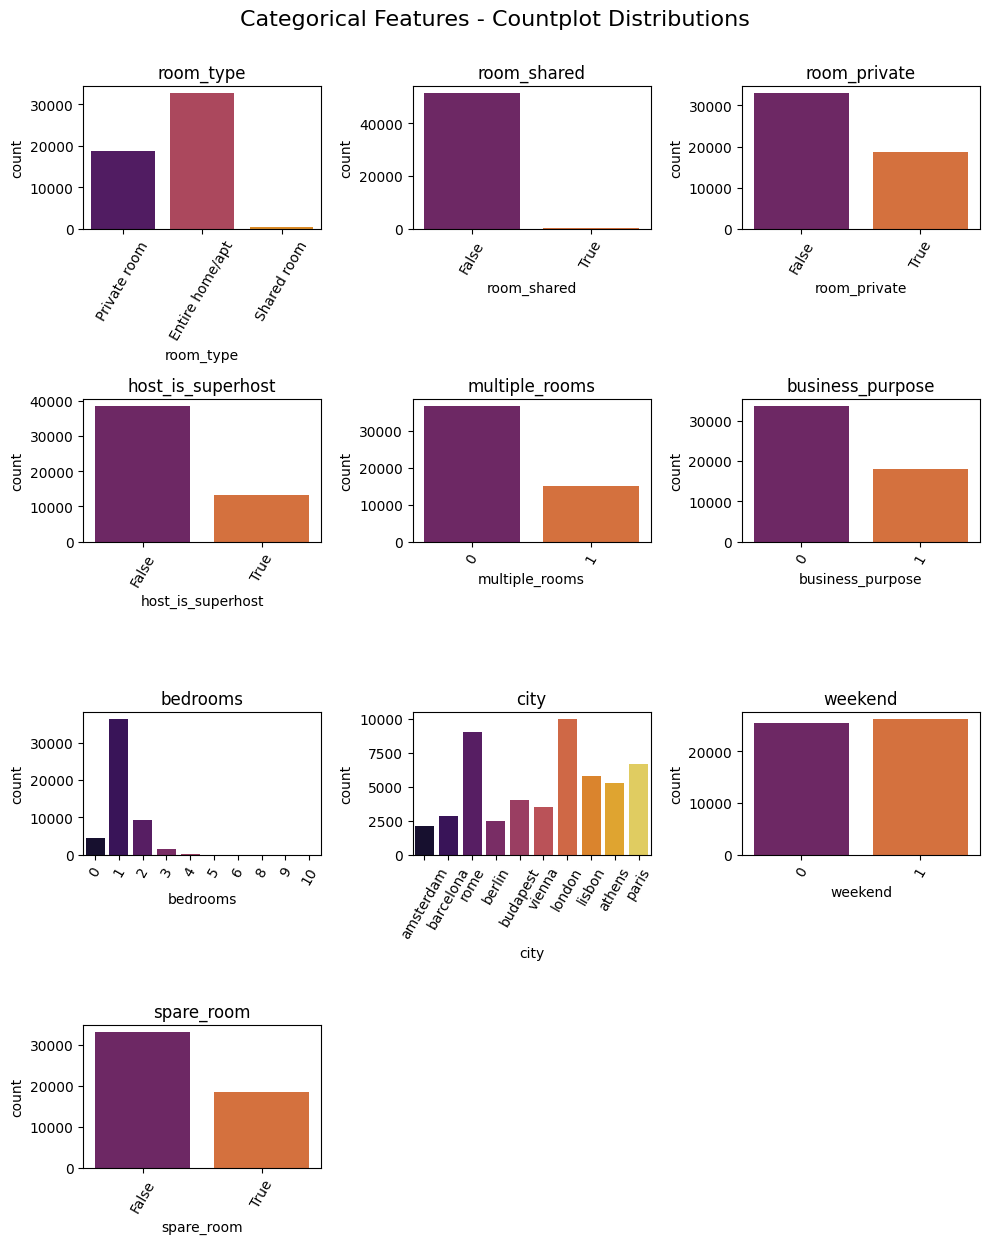

In [74]:
# Countplot Distributions - Categorical Features
fig, axes, cmap = init_subplots(4, 3, (10,12), df) # init subplot

for idx, col in enumerate(categorical_cols):
    ax = axes[idx]                                             # get subplot idx
    _, palette = color_palette(cmap, num_categorical, df, col) # init palette
    sns.countplot(df, x=col, ax=ax, palette=palette, hue=col, legend=False)
    ax.set_title(col)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="center")

for ax in axes[len(categorical_cols):]: ax.remove()
fig.text(0.5, 1.02, "Categorical Features - Countplot Distributions", fontsize=16, ha="center")
show_plots(df, fig, axes, None) # display plots

**Observations - Categorical**

Based on the *countplot* distributions, we can see that...

- ***Room Types:*** "Entire home/apt" is the majority of the listings, followed by "Private room" then "Shared room".

- ***Room Features:*** A significant number of listings have private rooms where its capacity is around 2-4 people.

- ***Superhost Status:*** Majority of hosts are not superhosts, suggesting that becoming a superhost is rare.

- ***City Distribution:*** Majority of listsings in London, followed by Rome and Paris. There are significant variations in the number of listings across the other cities.

- ***Weekend:*** Most listings are not flagged as "weekend", which might indicate mostly weekday stays or a lack of weekend-specific data.

### ii) Correlation Analysis

First, let's plot the correlation distributions for *numerical features* in the dataset using *scatterplots*.

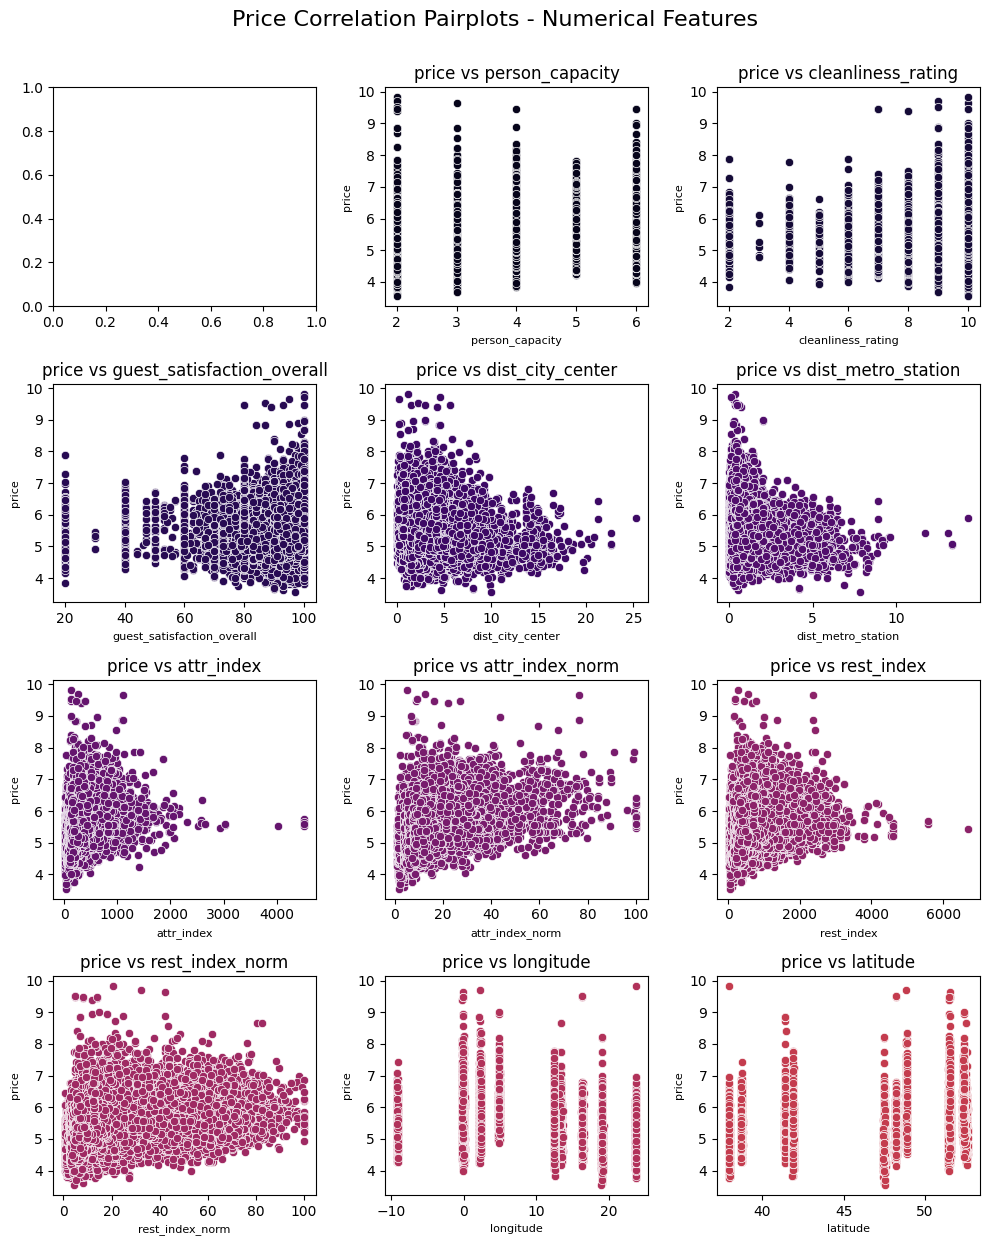

In [75]:
# Scatterplot Distributions - Numerical Features
fig, axes, cmap = init_subplots(4, 3, (10, 12), df) # init subplots
numerical_cols, _, _ = separate_features(df)        # separate types

for idx, col in enumerate(numerical_cols):
    if col == "price":  # skip price column
        continue

    else:
        ax = axes[idx]  # Get subplot
        color, _ = color_palette(cmap, idx, df, col)  # Init color
        sns.scatterplot(x=df[col], y=df["price"], ax=ax, color=color)
        ax.set_title(f"price vs {col}")
        ax.set_xlabel(col, fontsize=8)
        ax.set_ylabel("price", fontsize=8)

fig.text(0.5, 1.02, "Price Correlation Pairplots - Numerical Features", fontsize=16, ha="center")
show_plots(df, fig, axes, None)  # Display numerical pairplots

**Observations - Numerical:**

In relation to *price*, the following numerical features are...

- ***person_capacity:*** positively correlated

- ***guest_satisfaction_overall:*** positively correlated

- ***attr_index:*** positively correlated

- ***rest_index:*** positively correlated

- ***dist_city_center:*** negatively correlated

- ***location:*** not significantly correlated

Now let's plot the correlation distributions for *categorical features* in the dataset using *boxplots*.

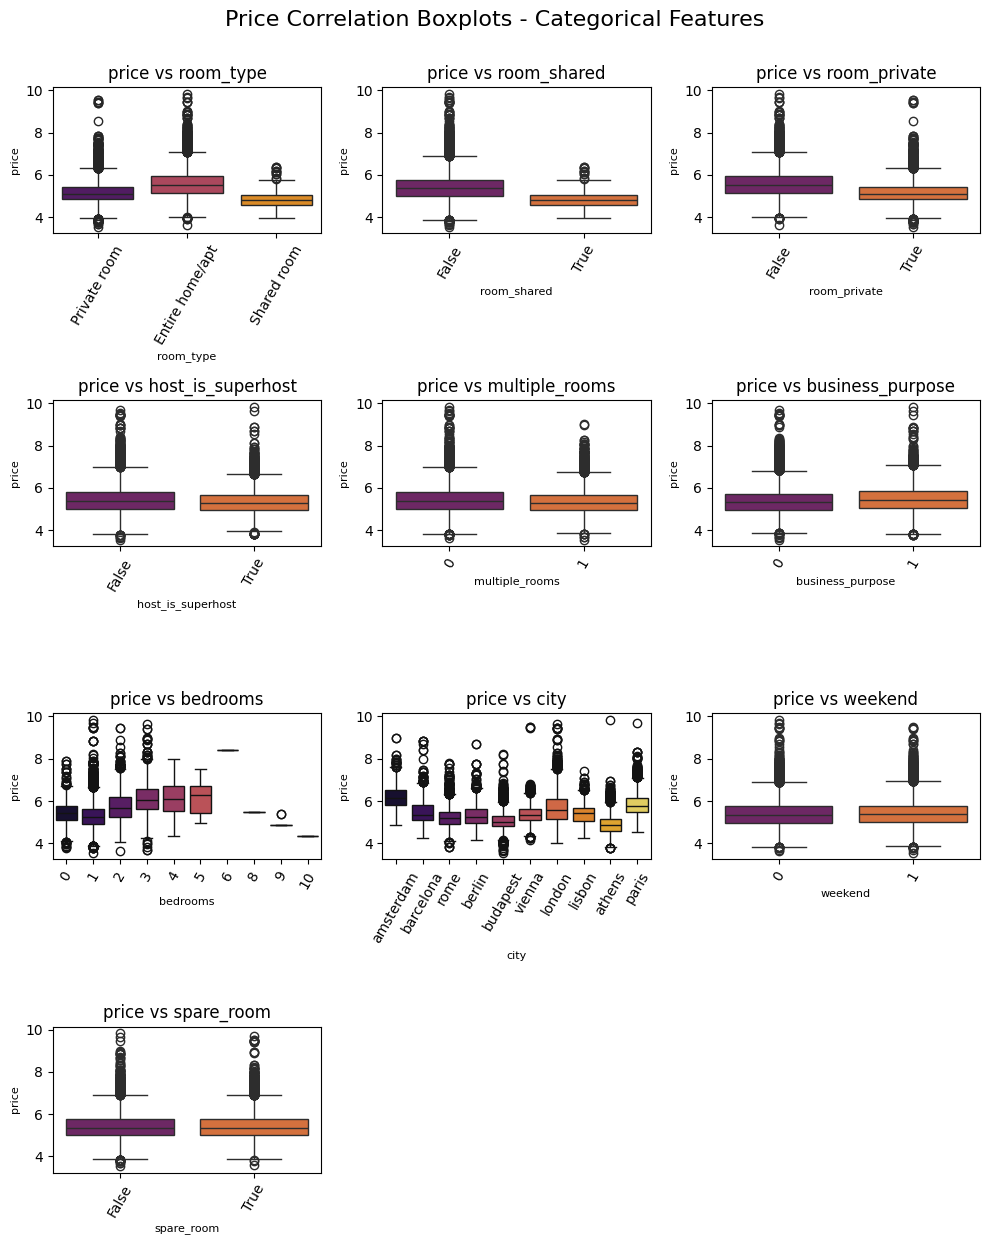

In [76]:
# Boxplot Distributions - Categorical Features
fig, axes, cmap = init_subplots(4, 3, (10, 12), df) # init subplots
_, categorical_cols, _ = separate_features(df)      # separate types

for idx, col in enumerate(categorical_cols):
    ax = axes[idx]  # Get subplot
    _, palette = color_palette(cmap, idx, df, col)  # init palette
    sns.boxplot(x=df[col], y=df["price"], ax=ax, palette=palette)
    ax.set_title(f"price vs {col}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="center")
    ax.set_xlabel(col, fontsize=8)
    ax.set_ylabel("price", fontsize=8)

for ax in axes[len(categorical_cols):]: ax.remove()
fig.text(0.5, 1.02, "Price Correlation Boxplots - Categorical Features", fontsize=16, ha="center")
show_plots(df, fig, axes, None)  # display plots

**Observations - Categorical:**

In relation to *price*, the following categorical features are...

- ***room_type:*** positively correlated

- ***host_is_superhost:*** positively correlated but weak

- ***multiple_rooms:*** positively correlated

- ***business_purpose:*** positively correlated

- ***city:*** not linearly correlated

- ***weekend:*** not correlated

## Principal Component Analysis (PCA)

Let's use *PCA Clustering* to gain more insight about the structure, relationships, and patterns in our dataset.

### i) Train, Test Split


In [77]:
# Train, Test, Split
X = df.drop(columns = ['price']) # drop "price" col
y = df['price']

# split into train, test, validation sets
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.15, random_state = 1234, shuffle = True)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.17647, random_state = 1234, shuffle = True)

### ii) Standardize Data

In [78]:
# Get Data
X_df = X_train
X_df = X_df.drop(columns = ['room_type']) # drop bc already encoded
X_df = pd.get_dummies(X_df)
X_df.head()

,room_shared,room_private,person_capacity,host_is_superhost,multiple_rooms,business_purpose,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist_city_center,...,city_amsterdam,city_athens,city_barcelona,city_berlin,city_budapest,city_lisbon,city_london,city_paris,city_rome,city_vienna
4521,False,True,2.0,False,0,0,9.0,100.0,1,6.075903,...,False,False,False,False,False,False,True,False,False,False
290,False,False,5.0,False,0,1,9.0,87.0,2,4.369525,...,False,False,False,False,False,False,False,False,True,False
870,False,False,2.0,False,0,0,10.0,98.0,1,3.091255,...,True,False,False,False,False,False,False,False,False,False
1421,False,False,4.0,True,0,1,10.0,97.0,1,0.039814,...,False,False,False,False,False,False,False,False,False,True
2336,False,False,6.0,False,1,0,10.0,93.0,2,1.663066,...,False,True,False,False,False,False,False,False,False,False


In [79]:
# Standardize Data
scaler = preprocessing.StandardScaler()
scaled_X_train_df = scaler.fit_transform(X_df)

# standardize X_test and X_valid
scaled_X_valid_df = X_valid.drop(columns = ['room_type'])
scaled_X_valid_df = pd.get_dummies(scaled_X_valid_df)
scaled_X_valid_df = scaler.transform(scaled_X_valid_df)

scaled_X_test_df = X_test.drop(columns = ['room_type'])
scaled_X_test_df = pd.get_dummies(scaled_X_test_df)
scaled_X_test_df = scaler.transform(scaled_X_test_df)

### iii) Conduct PCA

In [80]:
# Compute Explained Variance
pca = decomposition.PCA(random_state = 1234).fit(scaled_X_train_df)                  # perform PCA
explained_var = round(sum(pca.explained_variance_ratio_[:13]), 4) # compute explained variance
print(f"Explained Variance = {explained_var}")

Explained Variance = 0.7939


***Observation:*** Based on the explained variance computer above, the first 13 principal components explain around 79% of the variability in the data. This suggests that, after PCA, the reduced dimensions are still highly representative of the original data.

Let's transform the *training* data.

Note: We only want to keep the first 13 principal components because our model is able to explain around 79% of the variance in the data.

In [81]:
# Transformation - Training Data
scaled_X_train_df = pca.transform(scaled_X_train_df)
scaled_X_train_df = pd.DataFrame(scaled_X_train_df)
scaled_X_train_df.columns = ['PC_' + str(i) for i in range(1, 30)]
scaled_X_train_df = scaled_X_train_df.iloc[:,0:13]
scaled_X_train_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13
0,-1.712691,3.193686,-0.309537,0.666986,-0.023657,0.902727,0.425300,-1.266215,0.139233,-0.092340,-0.348882,-0.821986,-0.606879
1,0.043624,-1.387160,1.483642,0.082737,-2.225364,1.408144,0.915448,0.046598,-1.291920,0.383927,0.528670,0.523518,0.151572
2,-1.057089,1.076250,-1.780722,-0.833942,1.587615,0.643953,0.602393,-0.021819,0.614057,1.222647,2.222686,-1.615666,3.109531
3,3.387356,-0.281342,-2.036702,-1.126565,-1.844348,-0.548665,-3.299219,-2.003397,1.109515,-1.144864,2.149326,1.909484,0.638213
4,-2.141335,-3.496126,0.380653,-0.236422,-1.308794,0.237452,-0.276683,0.921875,2.133607,-0.209287,-1.789681,0.054693,0.698190


Let's take a look at the *eigenvectors* in the dataset.

They will help us determine how much each original feature contributes (weighs) to a principal component.

In [82]:
# Get Eigenvectors
eigenvectors = pd.DataFrame(pca.components_, columns =['PC_' + str(i) for i in range(1, 30)])
eigenvectors = eigenvectors.iloc[:, 0:13]
eigenvectors.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13
0,-0.002827,-0.034398,0.019341,-0.063069,-0.024443,0.138040,-0.068306,-0.091626,-0.024977,-0.278414,-0.193616,0.447330,0.360237
1,0.011009,0.252128,-0.244436,-0.165822,-0.012200,-0.055517,-0.153052,-0.134625,-0.131194,0.319640,0.154535,-0.001801,0.211553
2,0.046710,0.057867,0.055554,-0.192730,-0.043235,0.340797,-0.287464,-0.349573,0.059993,0.005787,0.052282,-0.103888,-0.186292
3,-0.099240,0.354720,-0.241051,0.174871,0.363230,-0.173546,0.230855,0.203600,-0.079598,0.119641,0.207380,0.152944,-0.091598
4,0.017812,0.091657,-0.252253,0.069162,-0.064594,-0.138818,0.244050,0.247389,-0.170691,-0.139518,-0.120480,-0.153106,-0.119709


Now let's visualize the eigenvectors for each principal component. More specifically, let's look at how much of each feature contributed to the corresponding principal component.

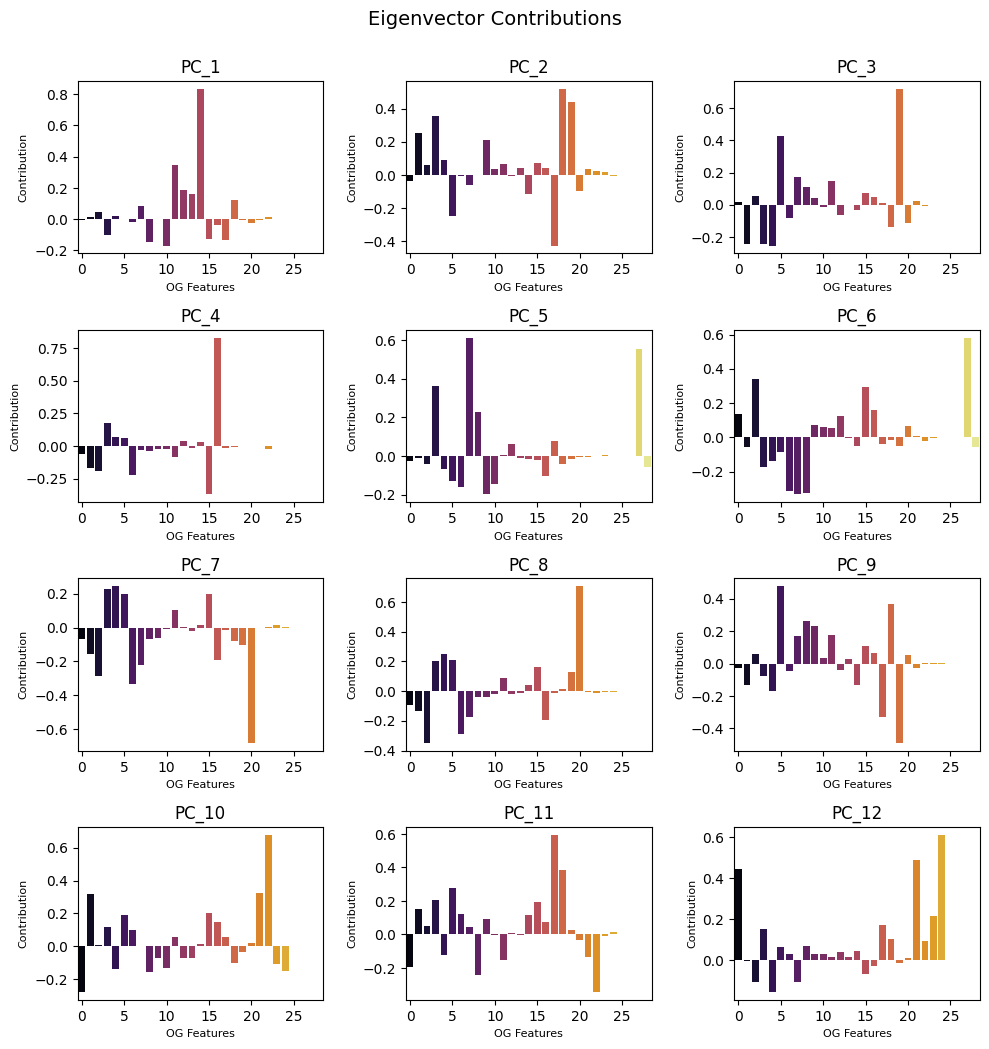

In [83]:
# Eigenvector Barplots
fig, axes, cmap = init_subplots(8, 3, (10,20), df) # init plots

for idx, PC in enumerate(eigenvectors.columns):
    ax = axes[idx] # get subplot idx
    palette = sns.color_palette("inferno", n_colors=len(eigenvectors.index))

    sns.barplot(x=eigenvectors.index, y=eigenvectors[PC], ax=ax, palette=palette)
    ax.set_title(PC)
    ax.set_xlabel("OG Features", fontsize=8)
    ax.set_ylabel("Contribution", fontsize=8)

    # setup x-ticks parameters
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::5]) # skip every 5 ticks
    ax.tick_params(axis='x')

fig.suptitle("Eigenvector Contributions", fontsize=14, y=1)
show_plots(eigenvectors, fig, axes, None) # display plots

***Observations:*** Based on these principal component barplots, many of the components have a single feature that has a significant, positive contribution. This suggests that those features contribute the most in terms of explaining the variance captured in that given principal component.

Now let's transform the *validation* and *test* data too so we can visualize the PCA results.

In [84]:
# Transformation - Valid Data
scaled_X_valid_df = pca.transform(scaled_X_valid_df)
scaled_X_valid_df = pd.DataFrame(scaled_X_valid_df)
scaled_X_valid_df.columns = ['PC_' + str(i) for i in range(1, 30)]
scaled_X_valid_df = scaled_X_valid_df.iloc[:,0:13]
scaled_X_valid_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13
0,-0.117809,-0.188833,0.087363,2.968578,-0.731812,-0.632424,1.102916,0.872458,-0.739551,-0.754537,-0.006295,-0.067324,0.152655
1,-1.797387,-0.285812,1.794951,-0.117580,2.726729,2.158250,0.751899,-0.301450,-0.115510,-0.589609,-0.026924,-0.198468,-0.868736
2,0.394811,2.111572,0.429428,-0.287886,-0.408841,-0.593390,-1.668885,-1.750125,-0.697488,-0.646799,-0.320483,-0.470071,0.259395
3,-1.866218,-0.470689,-1.153523,1.178058,0.225422,-1.953217,-1.662323,0.541737,0.898389,-2.081902,2.144191,1.398809,0.171719
4,0.344973,1.357324,-0.877147,-1.151301,0.066096,-1.565894,-1.320788,0.148630,-2.138228,2.678458,-1.017752,2.693102,0.670121


In [85]:
# Transformation - Test Data
scaled_X_test_df = pca.transform(scaled_X_test_df)
scaled_X_test_df = pd.DataFrame(scaled_X_test_df)
scaled_X_test_df.columns = ['PC_' + str(i) for i in range(1, 30)]
scaled_X_test_df = scaled_X_test_df.iloc[:,0:13]
scaled_X_test_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13
0,1.238770,1.579176,-0.864703,0.656966,-0.642250,0.437987,-2.018758,0.400197,1.276182,-0.678708,-0.668720,-0.106541,0.138653
1,-0.978237,-1.753793,-0.579115,0.328049,-0.660451,2.160189,1.602458,-0.265688,-0.245059,0.268709,0.583453,0.611915,-0.507967
2,1.472356,-1.859903,-1.377538,-1.758025,-0.285226,-0.744569,-2.161390,0.612621,-1.830171,0.655382,0.389904,-1.724521,-1.400367
3,-0.269135,-2.177090,-1.879621,-2.391286,-0.549657,2.034863,-0.647292,1.418945,0.127075,1.832186,0.777048,-0.711433,-2.329898
4,1.503511,-0.067821,2.987574,0.115679,1.683851,-0.472976,0.759951,2.299276,0.505267,-0.758704,-0.276208,-0.772817,-0.030591


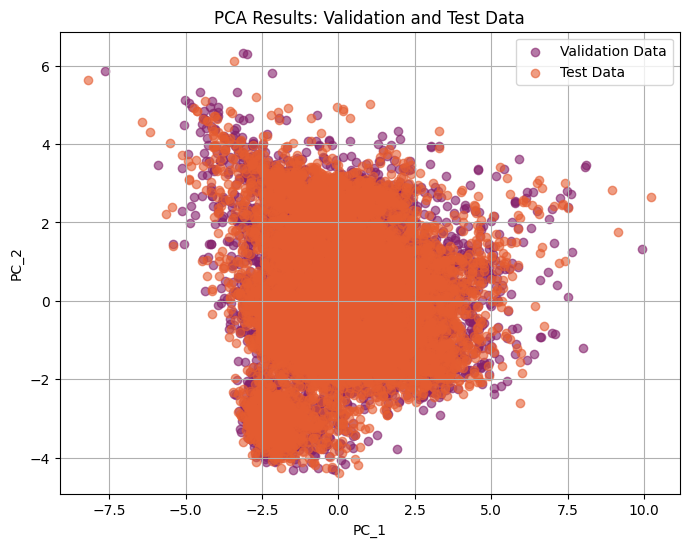

In [86]:
# PCA Scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(scaled_X_valid_df["PC_1"], scaled_X_valid_df["PC_2"], alpha=0.6, label="Validation Data", color="#84206b")
plt.scatter(scaled_X_test_df["PC_1"], scaled_X_test_df["PC_2"], alpha=0.6, label="Test Data", color="#e55c30")
plt.title("PCA Results: Validation and Test Data")
plt.legend()
plt.xlabel("PC_1")
plt.ylabel("PC_2")
plt.grid(True)
plt.show()

**Observations**

There's a significant overlap between *validation* and *test* datasets in the PCA space. This suggests...

- ***Consistency:*** The feature representation across these datasets is consistent

- ***Simplicity:*** Without distinct clustering and separation, the dataset doesn't show strong non-linear patterns

- ***Generalizability:*** Components can effectively represent unseen data (validation and test sets)

Based on the *PCA*, the identified principal components capture the variance in the dataset while reducing multicolinearity among features.

## Method I - Multi-Linear Regression (MLR)

For our first method, let's use *Multi-Linear Regression (MLR)* to build a model for predicting Airbnb prices while mitigating overfitting.

This model will help us to uncover the relationship between a *dependent* variable (price) and multiple *independent variables*.

### i) Initialize Training & Testing Variables

In [87]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [88]:
# Initialize Variables (X_train)
X_train = pd.get_dummies(X_train, columns=["room_type", "city"], drop_first=True)
X_train_np = X_train.values.astype(float)
X_train_np = np.hstack((X_train_np, np.ones((X_train_np.shape[0], 1)))) # add bias
y_train_np = y_train.values.astype(float)

# Initialize Variables (X_test)
X_test = pd.get_dummies(X_test, columns=["room_type", "city"], drop_first=True)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
X_test_np = X_test.values.astype(float)
X_test_np = np.hstack((X_test_np, np.ones((X_test_np.shape[0], 1)))) # add bias

### ii) Conduct Model

In [89]:
# Multi-Linear Regression
MLR_model = LinearRegression()
MLR_model.fit(X_train_np, y_train_np) # fit

LinearRegression()

### iii) Evaluate Model

In [90]:
# Functions for Evaluation Metrics
def adjusted_r2(y_test, X_train_np, r2):
    n = len(y_test)          # num observations
    k = X_train_np.shape[1]  # num predictors
    MLR_adjusted_r2 = 1 - ((1 - r2) * (n - 1)/(n - k - 1)) # adjusted R^2
    return MLR_adjusted_r2

def eval_metrics(mse, r2, adjusted_r2):
    print(f"Test MSE:    {mse:.3f}")
    print(f"Test R²:     {r2:.4f}")
    print(f"Adjusted R²: {adjusted_r2:.4f}")
    return

In [91]:
# Evaluate MLR Model
y_pred = MLR_model.predict(X_test_np)                     # prediction
MLR_mse = mean_squared_error(y_test.values, y_pred)       # mean-squared-error
MLR_r2 = r2_score(y_test.values, y_pred)                  # unadjusted R^2
MLR_adjusted_r2 = adjusted_r2(y_test, X_train_np, MLR_r2) # adjusted R^2
eval_metrics(MLR_mse, MLR_r2, MLR_adjusted_r2)            # print metrics

Test MSE:    0.119
Test R²:     0.6606
Adjusted R²: 0.6593


***Observations:*** These evaluation metric scores suggest that our model performs *reasonably well*. Since ~34% of the variability is not explained, this is likely due to missing features, randomness, and noise in our data.

## Analysis

### i) Numerical Comparison

In [92]:
# Compare Actual vs Predicted Prices
y_scaler = preprocessing.StandardScaler()
y_scaler.fit(y_train.values.reshape(-1, 1)) # fit on y_train data

# map city columns
city_columns = [col for col in X_test.columns if col.startswith("city_")] # find city cols
city_map = {col: col.split("_")[1] for col in city_columns}               # map col to city names
X_test["city"] = X_test[city_columns].idxmax(axis=1).map(city_map)        # find city name for each row

# create comparison_df
comparison_df = pd.DataFrame({
    "City" : X_test["city"],        # get city
    "Actual Price" : y_test.values, # actual prices
    "Predicted Price" : y_pred      # predicted prices
})

# inverse transformations on prices
comparison_df["Actual Price"] = y_scaler.inverse_transform(comparison_df[["Actual Price"]].values)
comparison_df["Actual Price"] = np.exp(comparison_df["Actual Price"])

comparison_df["Predicted Price"] = y_scaler.inverse_transform(comparison_df[["Predicted Price"]].values)
comparison_df["Predicted Price"] = np.exp(comparison_df["Predicted Price"])

# group by city and compute avg prices
comparison_grouped = comparison_df.groupby("City").mean()
comparison_grouped = comparison_grouped.applymap(lambda x: f"{x:,.2f}" if isinstance(x, (int, float)) else x)
comparison_grouped.reset_index(inplace=True)

print("  Actual vs Predicted Airbnb Prices ($)")
comparison_sorted = comparison_grouped.sort_values(by="Actual Price", ascending=True) # sort prices in ascending order
comparison_sorted

  Actual vs Predicted Airbnb Prices ($)


,City,Actual Price,Predicted Price
3,budapest,"4,860.07","4,756.48"
7,rome,"5,256.55","5,252.65"
4,lisbon,"5,755.33","5,709.88"
8,vienna,"5,764.98","5,661.88"
0,athens,"5,921.26","5,799.90"
2,berlin,"5,927.49","5,648.18"
1,barcelona,"6,261.63","5,981.14"
5,london,"7,191.25","6,788.92"
6,paris,"7,634.56","7,433.91"


In the table above are the average *average* and *predicted* prices of Airbnb listings per European city.

- ***Pros:*** The *predicted* prices align closely with the *actual* prices across all cities, indicating that our model performs well overall.

- ***Cons:*** There are slight variations, like in *London* and *Paris*, where the *predicted* values slightly underestimate the *actual* prices.

### ii) Graphical Comparison

Second, let's create several plots to visually analyze how our *MLR* model performed in predicting Airbnb prices.

Let's look at a *scatterplot*.

In [93]:
# Function - Plot Actual vs Predicted Prices
def comparison_scatterplot(y_test, y_pred, filename=None):
    min_price = min(y_test.min(), y_pred.min()) # compute min
    max_price = max(y_test.max(), y_pred.max()) # compute max

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(y_test, y_pred, alpha=0.7, color="#84206b", label="City Data")
    ax.plot([min_price, max_price], [min_price, max_price], "r--", color="#e55c30", label="Ideal Line")
    ax.set_title("Actual vs Predicted Airbnb Prices")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    ax.legend()

    if filename: fig.savefig(filename) # save figure for later

    return fig.show(), fig

(None, <Figure size 800x600 with 1 Axes>)

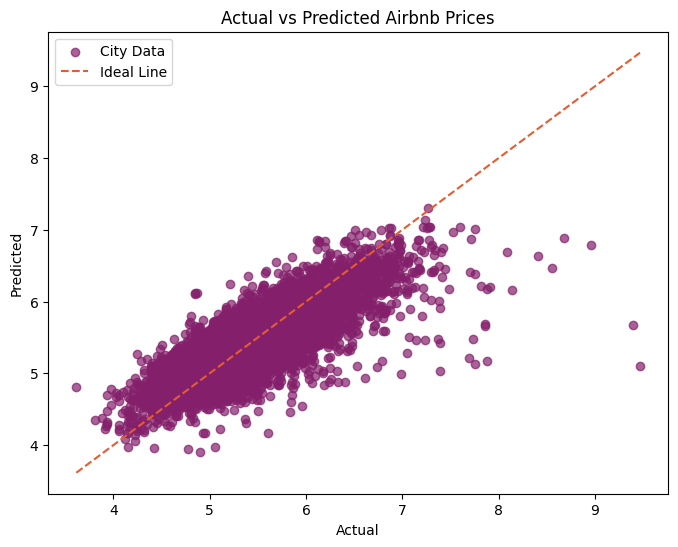

In [94]:
# Scatterplot
MLR_scatterplot = comparison_scatterplot(y_test, y_pred, filename="MLR_scatterplot.png")
MLR_scatterplot

Based on our *scatterplot* of actual vs predicted prices, our model...

- ***Performance:*** performs reasonably well given many predictions align closely with the *ideal line*

- ***Errors:*** contains some outliers that indicate areas where our model's predictions deviate more significantly from *actual* prices

Now let's look at a *barplot*.

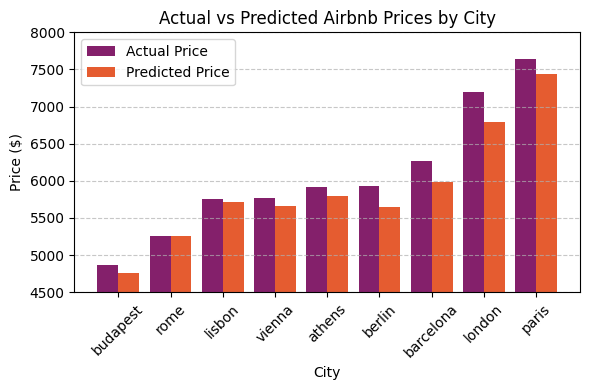

In [95]:
# Barcharts
comparison_sorted["Actual Price"] = comparison_sorted["Actual Price"].replace(',', '', regex=True).astype(float)
comparison_sorted["Predicted Price"] = comparison_sorted["Predicted Price"].replace(',', '', regex=True).astype(float)

# extract sorted values
cities = comparison_sorted["City"].values                      # city names
actual_prices = comparison_sorted["Actual Price"].values       # actual prices
predicted_prices = comparison_sorted["Predicted Price"].values # predicted prices
position = np.arange(len(cities))                              # x-axis position

# combine actual/predicted prices
all_prices = np.concatenate((actual_prices, predicted_prices))
min_price = np.floor(all_prices.min() / 500) * 500  # round to neareast 500
max_price = np.ceil(all_prices.max() / 500) * 500

# plot
plt.figure(figsize=(6, 4))
plt.bar(position - 0.2, actual_prices, width=0.4, label="Actual Price", color="#84206b")
plt.bar(position + 0.2, predicted_prices, width=0.4, label="Predicted Price", color="#e55c30")
plt.title("Actual vs Predicted Airbnb Prices by City")
plt.xlabel("City")
plt.ylabel("Price ($)")
plt.xticks(position, cities, rotation=45)     # city names
plt.ylim(min_price, max_price)                # ensure y-axis range matches data
plt.grid(axis="y", linestyle="--", alpha=0.7) # grid for y-axis only
plt.tight_layout()
plt.legend()
plt.show()

Based on our *barplot* of actual vs predicted prices by city, our model...

- ***Predictions:*** The *actual* Airbnb prices tend to be higher than our *predicted* prices for all cities.

- ***Highest Prices:*** Paris has the highest Airbnb prices, followed by London and Barcelona.

- ***Lowest Prices:*** Budapest has the lowest Airbnb prices, followed by Rome then Lisbon.

### Conclusion

We conclude that our *Multi-Linear Regression* model...

- Demonstrates a reasonable ability to predict Airbnb prices across various European cities.

- Contains certain city-specific factors may require additional consideration to enhance prediction accuracy.

- Provides insights that can help property owners and managers develop data-driven pricing strategies that reflect both competitive standards and localized dynamics.

***Suggestions:*** Because we can improve our model's performance, let's try more complex models like *Gradient Boosting* and *Deep Neural Networks* in order to more accurately predict Airbnb prices.These models will help us to capture complex, non-linear relationships between multiple features and *price*.

## Method II - Gradient Boosting

For our second method, let's use *Gradient Boosting* which will help us to...

- Handle outliers
- Get feature interactions
- Compute feature importance analysis

### i) Prepare Data

In [96]:
# Import Packages
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder

In [97]:
# One-Hot Encoding
df["room_shared"] = df["room_shared"].apply(lambda x: 1 if x else 0)
df["room_private"] = df["room_private"].apply(lambda x: 1 if x else 0)
df["host_is_superhost"] = df["host_is_superhost"].apply(lambda x: 1 if x else 0)
df["spare_room"] = df["spare_room"].apply(lambda x: 1 if x else 0)

df = pd.get_dummies(df, columns=["room_type"], drop_first=False)
df.head()

,price,room_shared,room_private,person_capacity,host_is_superhost,multiple_rooms,business_purpose,cleanliness_rating,guest_satisfaction_overall,bedrooms,...,rest_index,rest_index_norm,longitude,latitude,city,weekend,spare_room,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,5.268032,0,1,2.0,0,1,0,10.0,93.0,1,...,98.253896,6.846473,4.90569,52.41772,amsterdam,0,0,False,True,False
1,5.841356,0,1,4.0,0,0,0,8.0,85.0,1,...,837.280757,58.342928,4.90005,52.37432,amsterdam,0,1,False,True,False
2,5.576333,0,1,2.0,0,0,1,9.0,87.0,1,...,95.386955,6.646700,4.97512,52.36103,amsterdam,0,0,False,True,False
3,6.071960,0,1,4.0,0,0,1,9.0,90.0,2,...,875.033098,60.973565,4.89417,52.37663,amsterdam,0,0,False,True,False
4,6.185288,0,1,2.0,1,0,0,10.0,98.0,1,...,815.305740,56.811677,4.90051,52.37508,amsterdam,0,1,False,True,False


### ii) Conduct Model

In [98]:
# Run Model
X = df.drop(columns=["price", "city"]) # drop target/non-predictive cols
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)               # train
GB_X_train = X_train # need for later
GB_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42) # build model
GB_model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42)

### iii) Evaluate Model

In [99]:
# Evaluate GB Model
y_pred = GB_model.predict(X_test)                       # make predictions
GB_mse = mean_squared_error(y_test, y_pred)             # compute MSE
GB_r2 = r2_score(y_test, y_pred)                        # compute R^2
GB_adjusted_r2 = adjusted_r2(y_test, X_train_np, GB_r2) # adjusted R^2
eval_metrics(GB_mse, GB_r2, GB_adjusted_r2)             # print metrics

Test MSE:    0.089
Test R²:     0.7477
Adjusted R²: 0.7470


***Observations:*** These evaluation metric scores suggest that our model performs *well*! Since ~24% of the variability is not explained, our model's performance has improved from the *MLR* model.

## Analysis

Let's graphically visualize our results with a comparative *scatterplot*.

(None, <Figure size 800x600 with 1 Axes>)

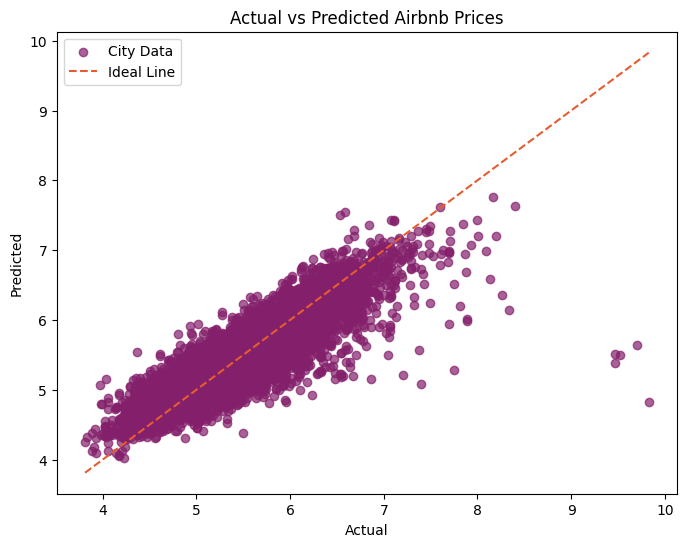

In [100]:
# Scatterplot
GB_scatterplot = comparison_scatterplot(y_test, y_pred, filename="GB_scatterplot.png")
GB_scatterplot

***Observations:*** Compared to our *MLR* model, the *Gradient Booster* model shows a tighter clustering of points along the ideal line, which indicates a better alignment between *predicted* and *actual* prices.

### Conclusion

Unlike our *Multi-Linear Regression* model, this model...

- ***Handles Non-Linearity:*** better captures complex, non-linear relationships between features *(room_type, dist_city)* and *price*

- ***Feature Interactions:*** identifies and models interactions between features like *[room_type, number_of_guests] or [city, availability]*, which leads to improved predictions

- ***Minimized Errors:*** decreased *MSE* in most cities, especially for cities with more variability *(Vienna and Budapest)*

## Method III - Deep Neural Networks

For our third method, let's use *Deep Neural Networks* which will help us to...

- Improve predictive accuracy on large datasets
- Explore advanced feature representations

### i) Prepare Data

In [101]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error

In [102]:

# Seperate target and feature variables
X = df.drop('price', axis=1)
y = df['price']

# Encode categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Scale numerical columns
scaler = StandardScaler()
X_scaled = X_encoded.copy()
X_scaled[numerical_columns] = scaler.fit_transform(X_scaled[numerical_columns])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.17647, random_state=42)

### ii) Conduct Model

In [103]:
# Define the model with tuned hyperparameters
def build_model(input_shape):
    model = keras.Sequential([
        layers.Dense(288, activation='relu', input_shape=[input_shape]),
        layers.Dense(320, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    optimizer = keras.optimizers.Adam(learning_rate=0.0002)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Train
input_shape = X_train.shape[1]
model = build_model(input_shape)
history = model.fit(
    X_train, y_train,
    validation_split=0.17647,
    epochs=100,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)

Epoch 1/100
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.3521 - val_loss: 0.1296
Epoch 2/100
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1199 - val_loss: 0.1107
Epoch 3/100
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1100 - val_loss: 0.1101
Epoch 4/100
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1065 - val_loss: 0.1046
Epoch 5/100
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1030 - val_loss: 0.1202
Epoch 6/100
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1027 - val_loss: 0.1035
Epoch 7/100
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1003 - val_loss: 0.1043
Epoch 8/100
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0965 - val_loss: 0.1046
Epoch 9/100
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0977 - val_loss: 0.1037
Epoch 10/100
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0991 - val_loss: 0.0983
Epoch 11/100
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0969 - val_loss: 0.1045
Epoch 12/100
1096/1

### iii) Evaluate Model

286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step
Root Mean Squared Error: 0.3223421878289572


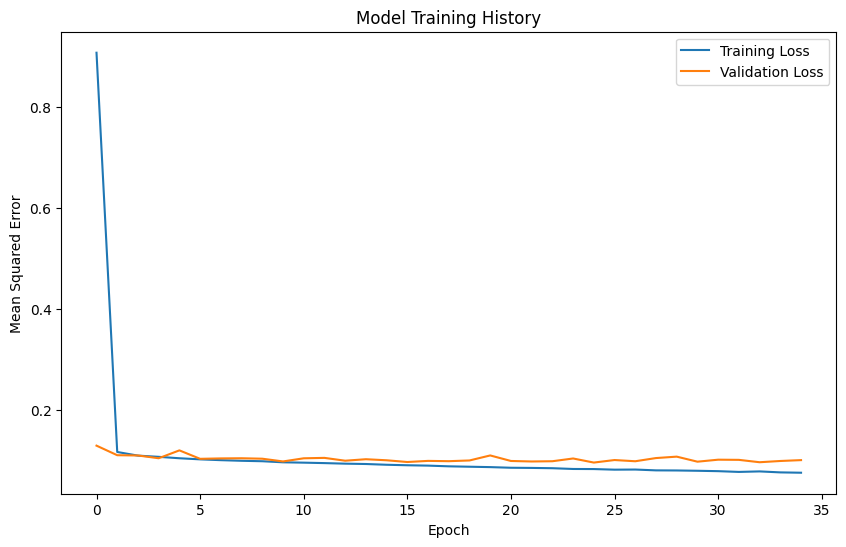

In [104]:
# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Model Training History')
plt.legend()
plt.show()

**Observations**

- ***Initial Convergence:*** training loss has a steep decline and stabilizes quickly, indicating that the model learns effectively
- ***After Convergence:*** both losses reach a pleteau with minimal fluctuations, which suggests that the model achieved a stable state

In [105]:
# Compute Evaluation Metrics
DNN_mae = mean_absolute_error(y_test, y_pred)             # mean-absolute error
DNN_mse = mean_squared_error(y_test, y_pred)              # mean-squared error
DNN_rmse = np.sqrt(DNN_mse)                               # root-mean-squared error
DNN_r2 = r2_score(y_test, y_pred)                         # R^2
DNN_adjusted_r2 = adjusted_r2(y_test, X_train_np, DNN_r2) # adjusted R^2
eval_metrics(DNN_mse, DNN_r2, DNN_adjusted_r2)            # print metrics

Test MSE:    0.104
Test R²:     0.7038
Adjusted R²: 0.7028


***Observations:*** Based on these evaluation metrics scores, our *Deep Neural Networks* model performs well and indicates a good fit.

### Analysis

Let's graphically visualize our results with a *scatterplot*.

(None, <Figure size 800x600 with 1 Axes>)

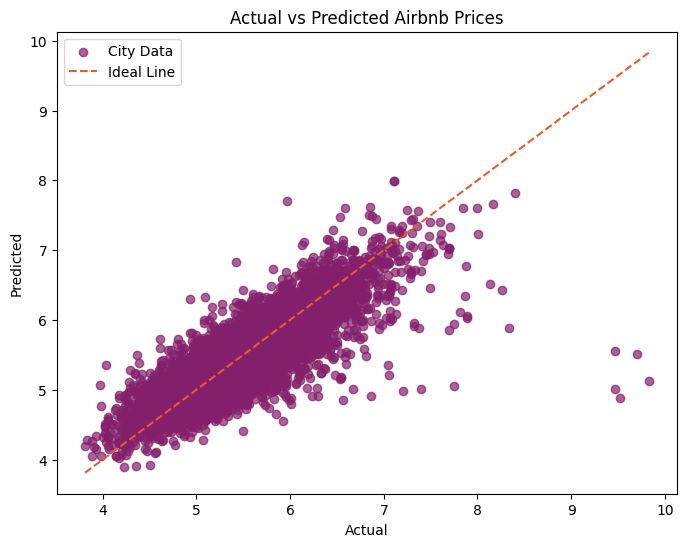

In [106]:
# Scatterplot
DNN_scatterplot = comparison_scatterplot(y_test, y_pred, filename="DNN_scatterplot.png")
DNN_scatterplot

***Observations:*** Compared to our *Gradient Booster* model, the *Deep Neural Network* model shows more dispersed clustering of points along the ideal line, which indicates a slightly worse alignment between *predicted* and *actual* prices.

Now let's plot our residuals from this model.

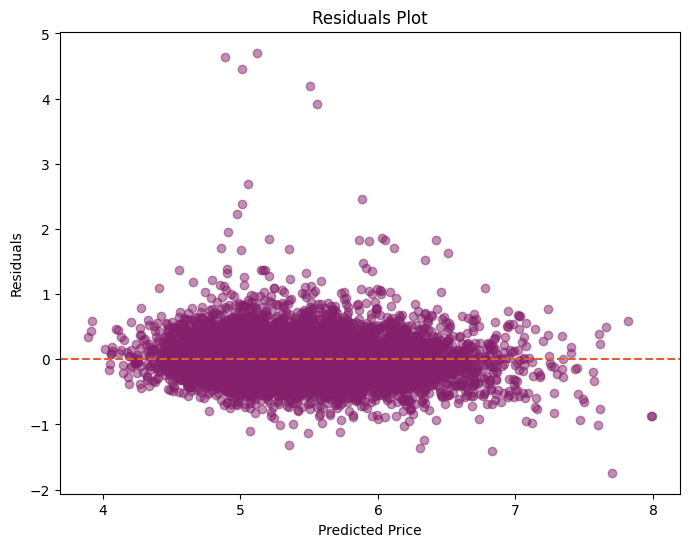

In [107]:
# Residuals Scatterplot
residuals = y_test - y_pred.flatten() # flatten

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color="#84206b")
plt.axhline(y=0, linestyle='--', color="#e55c30")
plt.title('Residuals Plot')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.show()

***Observations:*** The residuals are distributed around the zero line, indicating that the model has minimal bias in its predictions. However, there are a few significant outliers where the residuals are far from zero.

So let's try to optimize our *Deep Neural Networks* model with Tensorflow's *keras_tuner* package.

### i) Build Model

In [108]:
# # Run Optimal DNN Model
# import keras_tuner as kt

# def build_model(hp):
#     model = keras.Sequential()
#     model.add(keras.layers.Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32), activation='relu', input_shape=(X_train.shape[1],)))

#     for i in range(hp.Int('num_layers', 1, 4)):
#         model.add(keras.layers.Dense(units=hp.Int(f'units_{i+2}', min_value=32, max_value=512, step=32), activation='relu'))

#     model.add(keras.layers.Dense(1))
#     model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')), loss='mean_squared_error')
#     return model

### ii) Tune Hyperparameters

In [109]:
# # Tune Hyperparameters
# tuner = kt.Hyperband(
#     build_model,
#     objective='val_loss',
#     max_epochs=100,
#     factor=3,
#     directory='my_dir',
#     project_name='airbnb_price_prediction')

# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# tuner.search(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[stop_early])
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# print("The hyperparameter search is complete.\n")
# print(f"Optimal # of Layers:   {best_hps.get('num_layers')}")
# print(f"Optimal Learning Rate: {best_hps.get('learning_rate'):.4f}")

### iii) Evaluate Optimal Model

In [110]:
# # Evaluate Optimal Model
# model = tuner.hypermodel.build(best_hps)
# history = model.fit(X_train, y_train, epochs=100, validation_split=0.2) # fit model

# test_loss = model.evaluate(X_test, y_test)
# print(f"Test Loss: {test_loss}")

### Conclusion

We conclude that our *Neural Network* model...

- ***Performance:*** demonstrates a reasonable ability to *predict* Airbnb prices based on the accuracy and R^2

- ***Suggestions:***
    - Further tune parameters for optimal prediction
    - Potentially overfits the data due to the validation loss converging with training loss and then begins to increase. Could be a result of containing such a large sum of data

## Executive Summary

### i) Compare Model Performances

Let's compare our *Multi-Linear Regression*, *Gradient Booster*, and *Deep Neural Networks* models to identify which performed the best at predicting Airbnb prices.

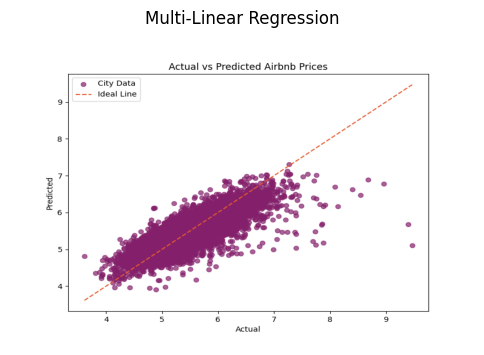

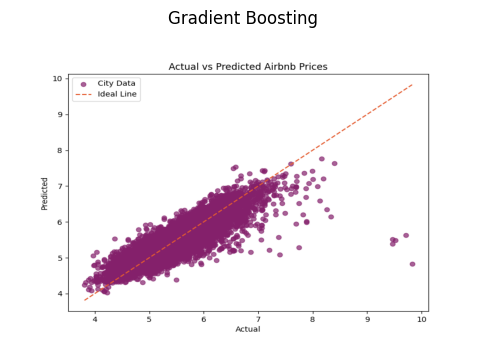

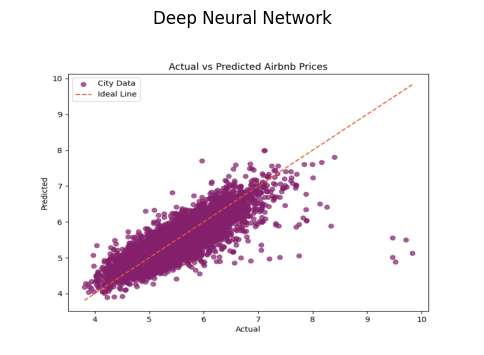

In [111]:
# Compare Results
saved_plots = [
    ("Multi-Linear Regression", "MLR_scatterplot.png"),
    ("Gradient Boosting", "GB_scatterplot.png"),
    ("Deep Neural Network", "DNN_scatterplot.png")
]
for title, filename in saved_plots:
    img = plt.imread(filename)
    plt.figure(figsize=(6, 4))
    plt.imshow(img, aspect="auto") # img fill plot space
    plt.axis("off")
    plt.title(title, pad=10)       # title padding
    plt.show()

Our *Gradient Boosting* model has the most dense clustering around the ideal line, indicating that it performed the best at predicting Airbnb prices out of the three models.

Let's look at our *evaluation metrics* MSE and R² now.

In [112]:
# Compare Evaluation Metrics
eval_metrics = {
    "Multi-Linear Regression": [round(MLR_mse, 3), round(MLR_r2, 4), round(MLR_adjusted_r2, 4)],
    "Gradient Boosting": [round(GB_mse, 3), round(GB_r2, 4),round(GB_adjusted_r2, 4)],
    "Deep Neural Networks": [round(DNN_mse, 3), round(DNN_r2, 4),round(DNN_adjusted_r2, 4)]
}
eval_metrics_df = pd.DataFrame.from_dict(eval_metrics, orient="index", columns=["MSE", "R²", "Adjusted R²"])
eval_metrics_df = eval_metrics_df.sort_values(by="MSE", ascending=True) # sort by MSE
eval_metrics_df

,MSE,R²,Adjusted R²
Gradient Boosting,0.089,0.7477,0.7470
Deep Neural Networks,0.104,0.7038,0.7028
Multi-Linear Regression,0.119,0.6606,0.6593


The *Gradient Boosting* has the smallest *MSE* and largest *R²*, which indicates that this model did indeed perform the best at predicting Airbnb prices.

### ii) Graphical Analysis

Let's look more closely at the *predicted* versus *actual* price comparisons for each European city using *Gradient Boosting*.

In [113]:
# Gradient Boosting - Actual vs Predicted by City
cities = df["city"].unique() # get unique cities
city_models = {}
city_results = {}
plot_data = {}    # store data for plotting

# Run GB Model For Each City
for city in df["city"].unique():
    city_df = df[df["city"] == city]
    X_city = city_df.drop(["price", "city"], axis=1)
    y_city = city_df["price"]

    X_train, X_test, y_train, y_test = train_test_split(X_city, y_city, test_size=0.2, random_state=42)  # split
    model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42) # model
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test) # make predictions
    mse = np.mean((y_pred - y_test.values) ** 2) # compute MSE
    r2 = r2_score(y_test, y_pred)                # compute R^2

    # store results
    city_models[city] = model
    city_results[city] = {"MSE": round(mse, 3), "R^2": round(r2, 3)}
    plot_data[city] = {"y_test": y_test.values, "y_pred": y_pred}  # save data for plotting

# Evaluate Each City
city_results_df = pd.DataFrame(city_results).T   # cities as rows
city_results_df.reset_index(inplace=True)        # reset index
city_results_df.columns = ["City", "MSE", "R^2"] # rename cols
city_results_df

,City,MSE,R^2
0,amsterdam,0.046,0.839
1,barcelona,0.078,0.743
2,rome,0.048,0.741
3,berlin,0.061,0.763
4,budapest,0.084,0.519
5,vienna,0.070,0.636
6,london,0.085,0.799
7,lisbon,0.041,0.784
8,athens,0.058,0.681
9,paris,0.065,0.747


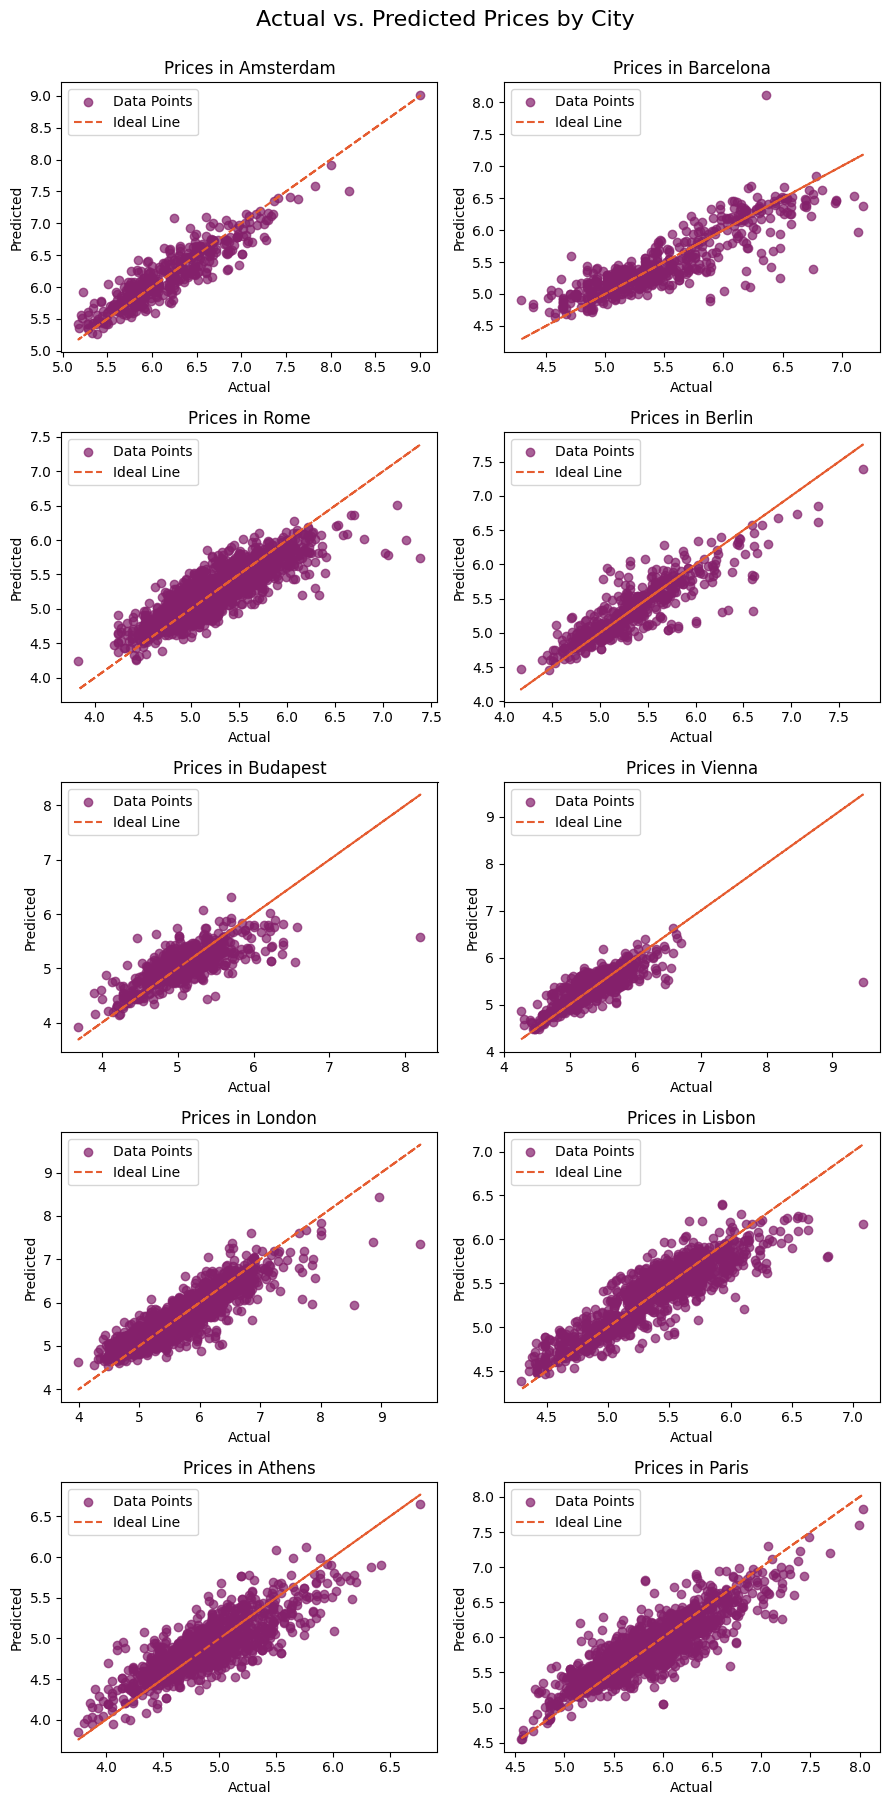

In [114]:
# Scatterplots - Actual vs Predicted by City
fig, axes = plt.subplots(5, 2, figsize=(9, 18)) # init subplots
axes = axes.flatten()                           # flatten axes array

for idx, (city, data) in enumerate(plot_data.items()):
    ax = axes[idx] # get subplot idx
    y_test = data["y_test"]
    y_pred = data["y_pred"]

    ax.scatter(y_test, y_pred, alpha=0.7, color="#84206b", label="Data Points")
    ax.plot(y_test, y_test, "r--", color="#e55c30", label="Ideal Line")
    ax.set_title(f"Prices in {city.title()}")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    ax.legend()

fig.suptitle("Actual vs. Predicted Prices by City", fontsize=16, y=1)
plt.tight_layout()
plt.show()

Based on our *scatterplot* of actual vs predicted prices for each city, our model...

- ***Performance:*** performs well across most cities while many cities *(Amsterdam, Berlin, and Rome)* demonstrate a strong fit

- ***Errors:*** show minor deviations for certain cities *(Budapest and Vienna)* based on the greater dispersion in their scatterplots

Now let's use *Gradient Boosting* to plot a *feature importance* barchart.

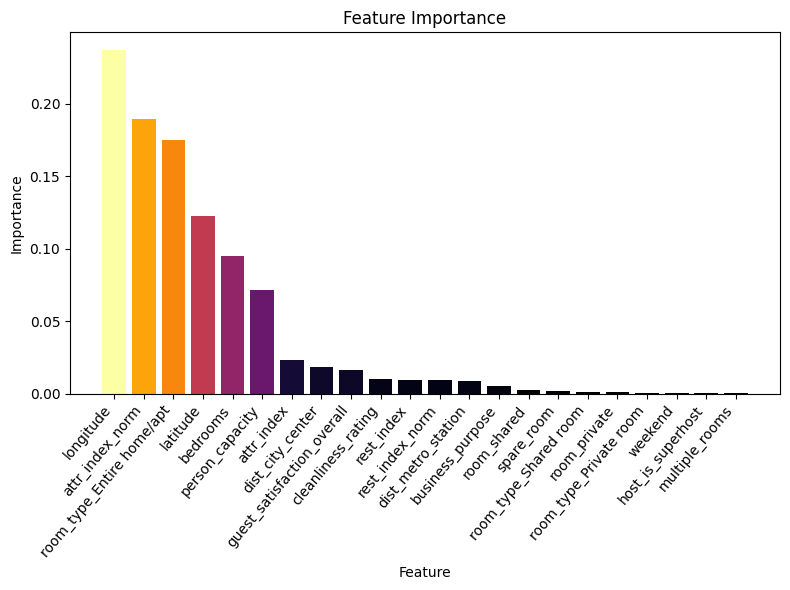

In [115]:
# Barchart - Feature Importance
importance_vals = GB_model.feature_importances_     # GradientBooster model
features = GB_X_train.columns                       # feature names
norm = plt.Normalize(importance_vals.min(), importance_vals.max()) # normalize scale
temp = np.argsort(importance_vals)[::-1]            # sort by importance
indices = [i for i in temp if features[i]]          # get idx
colors = cm.inferno(norm(importance_vals[indices])) # color cmap

# plot with inferno cmap
plt.figure(figsize=(8, 6))
plt.bar(range(len(indices)), importance_vals[indices], align="center", color=colors)
plt.xticks(range(len(indices)), [features[i] for i in indices], rotation=50, ha="right") # rotate labels
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [116]:
# Most Influential Features
top_5 = [features[i] for i in indices[:5]] # extract
last_5 = [features[i] for i in indices[-5:]]

top_5_importance = [round(importance_vals[i],2) for i in indices[:5]] # importance vals
last_5_importance = [round(importance_vals[i],4) for i in indices[-5:]]

top_features = {"Feature": top_5, "Importance": top_5_importance} # dict
last_features = {"Feature": last_5, "Importance": last_5_importance}

top_features_df = pd.DataFrame(top_features) # convert to DF
last_features_df = pd.DataFrame(last_features)

print(f"Most Influential Features:\n{top_features_df}\n")
print(f"Least Influential Features:\n{last_features_df}")

Most Influential Features:
                     Feature  Importance
0                  longitude        0.24
1            attr_index_norm        0.19
2  room_type_Entire home/apt        0.18
3                   latitude        0.12
4                   bedrooms        0.09

Least Influential Features:
                  Feature  Importance
0            room_private      0.0008
1  room_type_Private room      0.0007
2                 weekend      0.0007
3       host_is_superhost      0.0005
4          multiple_rooms      0.0004


### iii) Insights

Based on our optimal *Gradient Boosting* results, we gained practical business insights that *hosts* and *property owners* on Airbnb can benefit from.

- ***location:*** Since more centrally located listings tend to have higher prices, hosts can emphasize location or key areas in their listing descriptions.

- ***attr_index:*** Since the availability of nearby attractions heavily impacts pricing, hosts can highlight these attractions in their listings.

- ***person_capacity:*** Since listings that accommodate more people are priced higher, hosts can consider adding more beds to increase capacity and justify higher pricing.

- ***entire_home/apt:*** Since listings that offer the entire space tend to have higher prices, hosts can adjust listings to be tailored towards guests looking to book entire spaces.

- ***bedrooms:*** Since the number of bedrooms increases prices, hosts can emphasize bedroom features or add more beds.

## Conclusion

In conclusion, our analysis demonstrates that *Gradient Boosting* is the most effective model for predicting Airbnb prices across major European cities. *Gradient Boosting* outperformed *Multi-Linear Regression* and *Deep Neural Networks* in both accuracy and interpretability. Its predictions provide valuable insights that hosts and property owners at Airbnb can use to optimize their listings and maximize revenue based on key features like *location, capacity, and amenities*

## Table Cleanup

This part is for cleaning up the Python tables that we will include in our report.

In [117]:
# add model column because plotly does not recognize index values
eval_metrics_df['Model'] = eval_metrics_df.index
eval_metrics_df = eval_metrics_df[['Model',"MSE", "R²", "Adjusted R²"]]
eval_metrics_df

,Model,MSE,R²,Adjusted R²
Gradient Boosting,Gradient Boosting,0.089,0.7477,0.7470
Deep Neural Networks,Deep Neural Networks,0.104,0.7038,0.7028
Multi-Linear Regression,Multi-Linear Regression,0.119,0.6606,0.6593


In [120]:
# I used the example code from the offical website for pandas DataFrames as a template
# I also referenced the code under Alternating Row Colors (same source)
# Source: https://plotly.com/python/table/

import plotly.graph_objects as go


# fig1 is the table comparing the MSE and R^2 scores (both adjusted and not adjusted) for all the models
headerColor = 'grey'
rowEvenColor = 'lightgrey'
rowOddColor = 'white'


fig1 = go.Figure(data=[go.Table(
    header=dict(values= eval_metrics_df.columns,
                fill_color='grey',
                align='left',
                font=dict(color='white'),
                line_color='black'),
    cells=dict(values= [eval_metrics_df[col] for col in eval_metrics_df.columns],
               fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor]*4],
               align='left',
               font=dict(color='black'),
               line_color='black',))
])
fig1.update_layout(title = "Performance of Models")

fig1.show()

In [121]:
# making a dataframe for the gradient boosting model results
gb_test_results = pd.DataFrame(columns = ['Metric', 'Value'], data = [["Test MSE",round(GB_mse,4)],["Test R²", round(GB_r2,4)], ["Test Adjusted R²",round(GB_adjusted_r2,4)]])
gb_test_results

,Metric,Value
0,Test MSE,0.0888
1,Test R²,0.7477
2,Test Adjusted R²,0.7470


In [122]:
# fig2 is the results of the gradient boosting model

fig2 = go.Figure(data=[go.Table(
    header=dict(values= gb_test_results.columns,
                fill_color='grey',
                align='left',
                font=dict(color='white'),
                line_color='black'),
    cells=dict(values= [gb_test_results[col] for col in gb_test_results.columns],
               fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor]*4],
               align='left',
               font=dict(color='black'),
               line_color='black',))
])

fig2.update_layout(title = "Performance of Gradient Boosting Model")

fig2.show()

In [123]:
# fig3 is the table of the Most Influential Features

fig3 = go.Figure(data=[go.Table(
    header=dict(values= top_features_df.columns,
                fill_color='grey',
                align='left',
                font=dict(color='white'),
                line_color='black'),
    cells=dict(values= [top_features_df[col] for col in top_features_df.columns],
               fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor]*4],
               align='left',
               font=dict(color='black'),
               line_color='black',))
])

fig3.update_layout(title = "Most Influential Features")

fig3.show()

In [124]:
# fig4 is the table of the Most Influential Features

fig4 = go.Figure(data=[go.Table(
    header=dict(values= last_features_df.columns,
                fill_color='grey',
                align='left',
                font=dict(color='white'),
                line_color='black'),
    cells=dict(values= [last_features_df[col] for col in last_features_df.columns],
               fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor]*4],
               align='left',
               font=dict(color='black'),
               line_color='black',))
])

fig4.update_layout(title = "Least Influential Features")

fig4.show()
